In [1]:
% matplotlib inline

import numpy as np

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from scipy.special import gammaln
from scipy.stats import chisquare, chi2

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import h5py
import pywt

import readligo as rl

In [2]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs)/dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [3]:
fs = 4096 # sampling rate

# get segment list. note that for now, I'm only using a small amount of
# data (1 file), but that this should be expandable to many more (currently
# I have about 50GB worth of data cached on my home desktop, which should
# be more than enough for this)
start = 931035615
stop = 932245215
fl = rl.FileList()
segList = rl.getsegs(start, stop, 'H1', flag='DATA', filelist=fl)
print segList

Using data directory . ...
WARNING!  No file found for GPS 931033088 and IFO H1
WARNING! No file found with GPS start time 931033088
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931037184 and IFO H1
WARNING! No file found with GPS start time 931037184
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931041280 and IFO H1
WARNING! No file found with GPS start time 931041280
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931045376 and IFO H1
WARNING! No file found with GPS start time 931045376
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931057664 and IFO H1
WARNING! No file found with GPS start time 931057664
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931061760 and IFO H1
WARNING! No file found with GPS start time 931061760
Segment list may contain errors due to missing files.
WARNING!  No 

WARNING!  No file found for GPS 931749888 and IFO H1
WARNING! No file found with GPS start time 931749888
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931799040 and IFO H1
WARNING! No file found with GPS start time 931799040
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931889152 and IFO H1
WARNING! No file found with GPS start time 931889152
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931893248 and IFO H1
WARNING! No file found with GPS start time 931893248
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931897344 and IFO H1
WARNING! No file found with GPS start time 931897344
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931901440 and IFO H1
WARNING! No file found with GPS start time 931901440
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 93194240

In [4]:
# loop over good segments
#fn_H1 = 'cache/H-H1_LOSC_4_V2-1126257414-4096.hdf5' #'cache/H-H1_LOSC_4_V2-1126259446-32.hdf5'
# 'H-H1_LOSC_4_V2-1126257414-4096.hdf5'
#strain, time, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
#begin = time[0]
#end = time[-1]
#ts = time[1]-time[0]

event_data = np.array([])
for (begin, end) in segList: # for q in [0]:
    strain, meta, dq = rl.getstrain(begin, end, 'H1', filelist=fl)
    ts = meta['dt']
    time = np.arange(begin, end, ts)
    
    # first whiten strain data
    NFFT = 1*fs    
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    
#     plt.figure()
#     plt.loglog(freqs, np.sqrt(Pxx),'r',label='H1 strain')
#     plt.axis([10, 2000, 1e-24, 1e-19])
#     plt.grid('on')
#     plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
#     plt.xlabel('Freq (Hz)')
#     plt.title('Advanced LIGO strain data near GW150914')
#     plt.savefig('GW150914_prewhite.png')
    
    strain_whiten = whiten(strain,psd,ts)
    
    Pxx_white, freqs_white = mlab.psd(strain_whiten, Fs=fs, NFFT=NFFT)
    psd_white = interp1d(freqs_white, Pxx_white)
    
#     plt.figure()
#     plt.loglog(freqs_white, np.sqrt(Pxx_white),'r',label='H1 strain')
#     plt.grid('on')
#     plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
#     plt.xlabel('Freq (Hz)')
#     plt.title('Whitened Advanced LIGO strain data near GW150914')
#     plt.savefig('GW150914_white.png')
    
    bb, ab = butter(4, [20.*2./fs, 300.*2./fs],btype='band') #butterworth bandpass
    strain_whitenbp = filtfilt(bb, ab, strain_whiten)
    mid_slice = np.where((time - begin > 10.) & (end - time > 10.)) # slicing off the ends, which have been built up during whitening
    strain_whitenbp = strain_whitenbp[mid_slice]
    time = time[mid_slice]
    
    # plot of the whitened data and unwhitened data
    # not really relevant to final goals, but it shows the whitening is working!
#     figure1 = plt.figure(figsize=(10,8))
#     plt.subplot(2,1,1)
#     rel_time = np.arange(begin, end+ts, ts)
    
#     plt.plot(rel_time, strain)
#     plt.title('Raw Timeseries')
#     plt.xlabel('GPS Time($s$)')
    
#     plt.subplot(2,1,2)
#     plt.plot(rel_time, strain_whitenbp)
#     plt.title('Whitened Timeseries')
#     plt.xlabel('GPS Time($s$)')
    
#     plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    
    #------------------------------------------------------------
    
    # then wavelet decomposition.
    # returns [cA_n, cD_n, cD_n-1, ..., cD2, cD1]
    # where n is the decomposition level, and cA are the approximation coefficient arry
    # while cD are details coefficient arrays
    coeffs = pywt.wavedec(strain_whitenbp, 'haar') # using haar for now, as thats what LIGO apparently uses for this. will do more research later to verify reasoning
    D_coeffs = np.flipud(coeffs[1:]) # switching the order so that D_coeffs[i] corresponds to j=i+1 decomp level
    
    E_coeffs = []
    seg_times = []
    all_scales = []
    for scale, D_co in enumerate(D_coeffs):
        N = len(D_co)
        sigma = np.std(D_co)
        if (sigma == 0):
            break
        sig_px = np.where(abs(D_co / sigma) > 5.)[0]
        
        scales = np.full(np.shape(sig_px),scale+1,dtype=np.int64)

        times = np.full(np.shape(sig_px),begin,dtype=np.float64)
        for i in range(len(sig_px)):
            times[i] += ((2.**(scale+1.)) / fs) * sig_px[i]
            
        seg_times = np.append(seg_times, times)
        all_scales = np.append(all_scales,scales).astype(np.int64)

        E_coeffs = np.append(E_coeffs,((D_co**2) /  (np.std(D_co)**2))[sig_px])
    
    data = np.vstack((seg_times, all_scales * ts)).T # multiplying by ts to rescale the scale axis
    #bw = 100. #set bandwidth to 2 "pixels"
    
    ms = MeanShift()#bandwidth=bw)
    ms.fit(data)
    
    labels = ms.labels_
    centers = ms.cluster_centers_
    
#     fig2 = plt.figure(figsize=(10,8))
#     plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
#     plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
#     plt.legend()
#     plt.title('')
#     plt.xlabel('GPS Time ($s$)')
#     plt.ylabel('$j$')
#     plt.savefig('GW150914_cluster.png')
    
    #------------------------------------------------------------
    found = False
    for label in np.unique(labels):
        pts = np.where(labels==label)
        clust = E_coeffs[pts]
        E_c = np.sum(clust)
        x = np.linspace(0,1000,1000)
    
        signif = -np.log(quad(chi2.pdf, E_c, np.inf, args=(len(clust),))[0])
        if (signif > 20.):
            cbc = False
            burst = False
            stoch = False
            b = min(seg_times[pts])
            e = max(seg_times[pts])
            del_t = e - b
            
            inj_slice = rl.dq_channel_to_seglist(dq['HW'])
            for sl in inj_slice:
                found = True
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                print('********************')
                print(inj_start,inj_end)
                print('--------------------')
                print(b, e)
                print('********************')
                if ((b > inj_start and b < inj_end) or (e > inj_start and e < inj_end)):
                    cbc = True
                    break
    
            
            
            if (len(event_data) == 0):
                event_data = np.array([b,e,del_t,signif,begin,end,cbc,burst,stoch])
            else:
                time_coords = np.array([b,e,del_t,signif,begin,end,cbc,burst,stoch])
                event_data = np.vstack((event_data,time_coords))
    
    if (found):
        break

print(len(np.unique(labels)))
# header = 'begin end del_t signif seg_begin seg_eng cbc burst stoch'
# np.savetxt('H1_times.csv', event_data, delimiter=' ', header=header)
# print("done")

Loading ./cache/H1/H-H1_LOSC_4_V1-931049472-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931053568-4096.hdf5

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log



Loading ./cache/H1/H-H1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931078144-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931078144-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931078144-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931082240-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931082240-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931086336-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931090432-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931094528-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931123200-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931123200-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931127296-4096.hdf5
Loading ./cache/H1/H-H1_LOSC_4_V1-931131392-4096.hdf5
********************
(931130684.00024414, 931130821.0)
--------------------
(931130430.9375, 931131452.99902344)
********************
********************
(931130684.00024414, 931130821.0)
--------------------
(931127116.99902344, 931128802.63183594)
********************
********************
(931

[ 0.03919309  0.03709384 -0.0058177  -0.05693354 -0.07840221 -0.05841515
 -0.0052927   0.0716621   0.15226487  0.18548399  0.11895842 -0.03342768
 -0.17181287 -0.18645248 -0.06780744  0.0727777   0.1129748   0.04006014
 -0.05649113 -0.09427279 -0.07047591 -0.02980509  0.00469697  0.04332781
  0.0896012   0.11877718  0.10338306  0.05026977 -0.00034449 -0.02129984
 -0.02817426 -0.04345556 -0.05545535 -0.04170217 -0.01025459  0.00719844
 -0.00514674 -0.02666511 -0.02591856  0.00042251  0.0258974   0.0307879
  0.03058925  0.05029206  0.07326984  0.04967073 -0.03299451 -0.11692201
 -0.13233773 -0.07598415]
0.059676139275


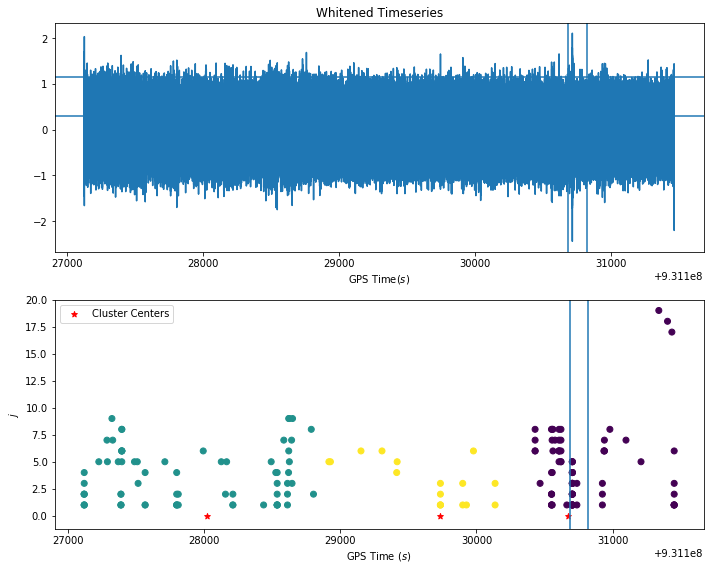

In [5]:
figure1 = plt.figure(figsize=(10,8))
plt.rcParams['agg.path.chunksize'] = 10000

# rel_time = np.arange(begin, end, ts)

# where_slice = np.where((rel_time - begin > 10.) & (end - rel_time > 10.))
# where_sliceb = np.where((rel_time - begin > 0.0175))
# where_slicee = np.where((end - rel_time > 0.0175))
# print(strain_whitenbp[where_slice])
print(D_coeffs[0][5000:5050])
print(np.std(D_coeffs[0]))

plt.subplot(2,1,1)
plt.plot(time, strain_whitenbp)
plt.title('Whitened Timeseries')
plt.xlabel('GPS Time($s$)')
plt.axvline(x=inj_start)
plt.axvline(x=inj_end)
plt.axhline(y=np.std(strain_whitenbp))
plt.axhline(y=np.std(4 * strain_whitenbp))

plt.subplot(2,1,2)
plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
plt.legend()
plt.title('')
plt.xlabel('GPS Time ($s$)')
plt.ylabel('$j$')
plt.axvline(x=inj_start)
plt.axvline(x=inj_end)

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.show()

In [6]:
print(100 / ts, 500000. * ts)

(409600.0, 122.0703125)
